In [ ]:
from google.colab import files
uploaded = files.upload()  # Select your kaggle.json file when prompted


Saving kaggle.json to kaggle.json


In [ ]:
# Create the Kaggle configuration directory
!mkdir -p ~/.kaggle

# Copy the uploaded kaggle.json to the configuration directory
!cp kaggle.json ~/.kaggle/

# Set permissions so that only you can read the file
!chmod 600 ~/.kaggle/kaggle.json

# Verify that the file is in place
!ls -la ~/.kaggle/


total 16
drwxr-xr-x 2 root root 4096 Apr  3 19:07 .
drwx------ 1 root root 4096 Apr  3 19:05 ..
-rw------- 1 root root   74 Apr  3 19:07 kaggle.json


In [ ]:
# Step 3: Download and Unzip Datasets from Kaggle

# Download the Sentiment140 dataset from Kaggle
!kaggle datasets download -d kazanova/sentiment140

# Create a directory for the Sentiment140 dataset and unzip it
!mkdir -p /content/sentiment140
!unzip -o sentiment140.zip -d /content/sentiment140

# Download the US Comments Cleaned dataset (YouTube Comments) from Kaggle
!kaggle datasets download -d harshvardhan21/us-comments-cleaned-dataset-for-sentiment-analysis

# Create a directory for the YouTube Comments dataset and unzip it
!mkdir -p /content/youtube_comments
!unzip -o us-comments-cleaned-dataset-for-sentiment-analysis.zip -d /content/youtube_comments

# Verify that the files are in place
!ls -la /content/sentiment140
!ls -la /content/youtube_comments


Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
Archive:  sentiment140.zip
  inflating: /content/sentiment140/training.1600000.processed.noemoticon.csv  
Dataset URL: https://www.kaggle.com/datasets/harshvardhan21/us-comments-cleaned-dataset-for-sentiment-analysis
License(s): CC0-1.0
Archive:  us-comments-cleaned-dataset-for-sentiment-analysis.zip
  inflating: /content/youtube_comments/US_comments_Cleaned.csv  
total 233220
drwxr-xr-x 2 root root      4096 Apr  3 19:08 .
drwxr-xr-x 1 root root      4096 Apr  3 19:08 ..
-rw-r--r-- 1 root root 238803811 Sep 21  2019 training.1600000.processed.noemoticon.csv
total 74624
drwxr-xr-x 2 root root     4096 Apr  3 19:08 .
drwxr-xr-x 1 root root     4096 Apr  3 19:08 ..
-rw-r--r-- 1 root root 76406373 Feb  7  2024 US_comments_Cleaned.csv


In [ ]:
import pandas as pd
import re

# ----- Load and Preprocess the Sentiment140 Dataset -----
sentiment140_path = "/content/sentiment140/training.1600000.processed.noemoticon.csv"
sentiment140_df = pd.read_csv(sentiment140_path, encoding="latin-1", header=None)

# Assign headers (Sentiment140 dataset typically doesn't include them)
sentiment140_df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
print("Sentiment140 dataset shape:", sentiment140_df.shape)
print("First 5 rows of Sentiment140 dataset:")
print(sentiment140_df.head())

# ----- Load and Preprocess the YouTube Comments Dataset -----
youtube_comments_path = "/content/youtube_comments/US_comments_Cleaned.csv"
youtube_df = pd.read_csv(youtube_comments_path, dtype={"likes": str, "replies": str}, low_memory=False)
print("YouTube Comments dataset shape:", youtube_df.shape)
print("First 5 rows of YouTube Comments dataset:")
print(youtube_df.head())

# ----- Define a Text Cleaning Function -----
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Convert text to lowercase and trim whitespace
    return text.lower().strip()

# Apply cleaning to the Sentiment140 dataset
sentiment140_df['clean_text'] = sentiment140_df['text'].apply(clean_text)
print("Cleaned Sentiment140 sample:")
print(sentiment140_df[['clean_text']].head())

# Apply cleaning to the YouTube Comments dataset (using 'comment_text' column)
youtube_df['clean_text'] = youtube_df['comment_text'].apply(clean_text)
print("Cleaned YouTube Comments sample:")
print(youtube_df[['clean_text']].head())


Sentiment140 dataset shape: (1600000, 6)
First 5 rows of Sentiment140 dataset:
   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
YouTube Comments dataset shape: (691374, 5)
First 5 rows of YouTube Comments dataset:
   Unnamed: 

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Disable parallelism to avoid warnings

import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Sample 1,000 rows from the Sentiment140 dataset for quick testing
sample_df = sentiment140_df.sample(n=1000, random_state=42).copy()

# Convert labels: Sentiment140 uses 0 for negative and 4 for positive.
# We'll map label 0 to 0 and label 4 to 1 for binary classification.
sample_df['target'] = sample_df['target'].apply(lambda x: 0 if x == 0 else 1)

# Split the sample into training and evaluation sets (90% train, 10% eval)
train_df, eval_df = train_test_split(sample_df, test_size=0.1, random_state=42)

# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Define a custom dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.texts = df['clean_text'].tolist()
        self.labels = df['target'].tolist()
        self.encodings = tokenizer(self.texts, truncation=True, padding=True, max_length=128)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# Create PyTorch datasets
train_dataset = SentimentDataset(train_df)
eval_dataset = SentimentDataset(eval_df)

# Load pre-trained DistilBERT model for sequence classification with 2 classes
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
print("Model loaded. Note: Some classifier weights are newly initialized and will be trained.")

# Set up training arguments for quick testing (1 epoch)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,  # 1 epoch for fast execution
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch"  # Evaluate at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

# Start training
trainer.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Model loaded. Note: Some classifier weights are newly initialized and will be trained.


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nagamedha-sakhamuri98 (nagamedha-sakhamuri98-georgia-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.655200,0.507963


TrainOutput(global_step=57, training_loss=0.6750040807222065, metrics={'train_runtime': 31.2079, 'train_samples_per_second': 28.839, 'train_steps_per_second': 1.826, 'total_flos': 23983843467600.0, 'train_loss': 0.6750040807222065, 'epoch': 1.0})

Evaluation Results: {'eval_loss': 0.5079633593559265, 'eval_runtime': 0.2982, 'eval_samples_per_second': 335.357, 'eval_steps_per_second': 23.475, 'epoch': 1.0}

Accuracy: 0.8700
Precision: 0.9184
Recall:    0.8333
F1 Score:  0.8738


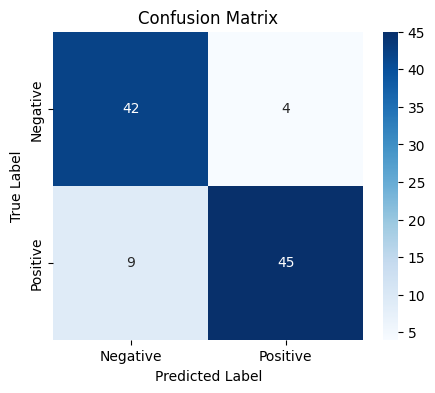

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Evaluate the model on the evaluation dataset
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Get predictions on the evaluation dataset
pred_output = trainer.predict(eval_dataset)
logits = pred_output.predictions
true_labels = pred_output.label_ids

# Convert logits to predicted labels (0 or 1)
pred_labels = np.argmax(logits, axis=1)

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def predict_sentiment(text_list, model, tokenizer, max_length=128):
    """Tokenize a list of text entries and predict sentiment using the trained model."""
    # Tokenize and convert to torch tensors
    encodings = tokenizer(text_list, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    # Move all tensors to the same device as the model
    encodings = {key: val.to(model.device) for key, val in encodings.items()}
    with torch.no_grad():
        outputs = model(**encodings)
    # Convert logits to predicted labels (0 or 1)
    logits = outputs.logits.detach().cpu().numpy()
    preds = np.argmax(logits, axis=1)
    return preds


In [ ]:
import numpy as np

# 1. Sample a few rows from the YouTube dataset
sample_youtube = youtube_df.sample(n=5, random_state=42).copy()

# 2. Predict sentiment on the 'clean_text' column using the updated function
pred_labels = predict_sentiment(sample_youtube['clean_text'].tolist(), model, tokenizer)

# 3. Print out results with label mapping
label_map = {0: "Negative", 1: "Positive"}
sample_youtube["predicted_sentiment"] = [label_map[label] for label in pred_labels]

print(sample_youtube[["comment_text", "clean_text", "predicted_sentiment"]])


                                             comment_text  \
11547                                            #Respect   
347478                      Nick Jonas is just the cutest   
547271            Wow your amazing agghh sooo talented 😳🙌   
470391                    Still is, REAL MEN WEAR PINK ;)   
238328  Omg, I just found out that she lives in my tow...   

                                               clean_text predicted_sentiment  
11547                                                                Negative  
347478                      nick jonas is just the cutest            Positive  
547271            wow your amazing agghh sooo talented 😳🙌            Positive  
470391                    still is, real men wear pink ;)            Positive  
238328  omg, i just found out that she lives in my tow...            Negative  


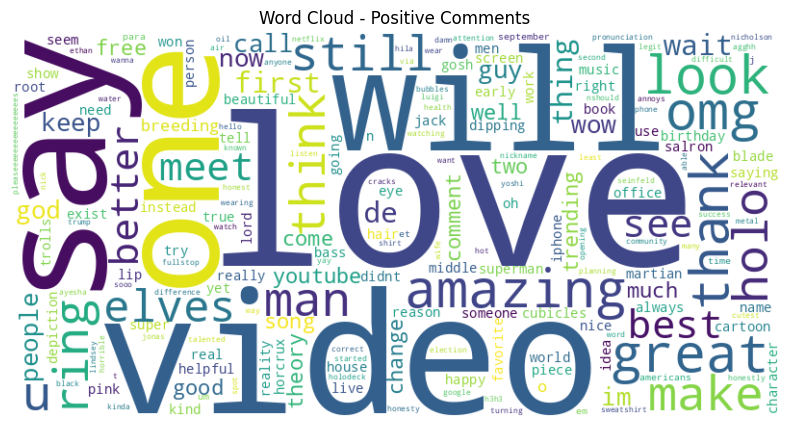

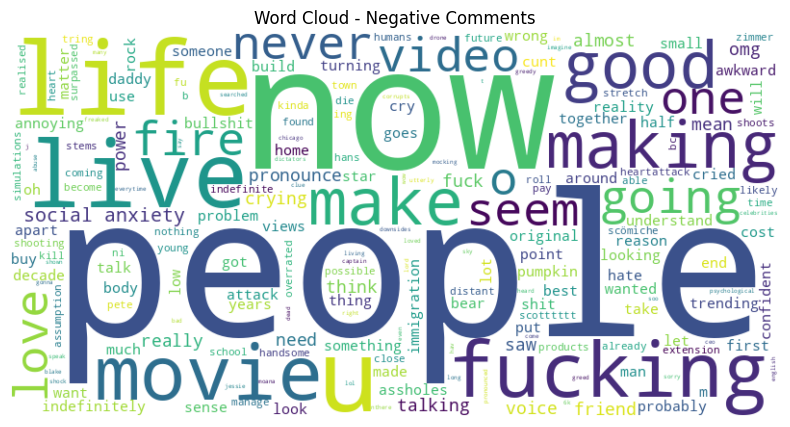

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample 200 rows from the YouTube Comments dataset for visualization
sample_youtube_large = youtube_df.sample(n=200, random_state=42).copy()

# Predict sentiment for the sample
pred_labels_large = predict_sentiment(sample_youtube_large['clean_text'].tolist(), model, tokenizer)
sample_youtube_large['predicted_sentiment'] = pred_labels_large
sample_youtube_large['predicted_sentiment_label'] = sample_youtube_large['predicted_sentiment'].apply(lambda x: "Positive" if x==1 else "Negative")

# Concatenate all clean text for each sentiment group
positive_text = " ".join(sample_youtube_large[sample_youtube_large['predicted_sentiment_label'] == "Positive"]['clean_text'].tolist())
negative_text = " ".join(sample_youtube_large[sample_youtube_large['predicted_sentiment_label'] == "Negative"]['clean_text'].tolist())

# Generate word cloud for positive comments
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positive Comments")
plt.show()

# Generate word cloud for negative comments
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negative Comments")
plt.show()


Sentiment distribution:
 predicted_sentiment_label
Positive    307
Negative    193
Name: count, dtype: int64


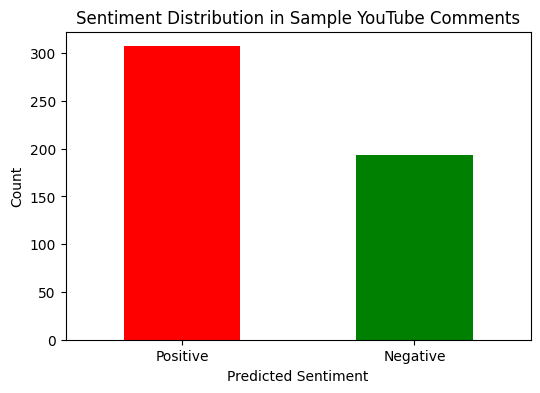

In [ ]:
# Sample 500 rows from the YouTube dataset for sentiment distribution
sample_youtube_distribution = youtube_df.sample(n=500, random_state=42).copy()

# Predict sentiment for these samples
pred_labels_distribution = predict_sentiment(sample_youtube_distribution['clean_text'].tolist(), model, tokenizer)
sample_youtube_distribution['predicted_sentiment'] = pred_labels_distribution
sample_youtube_distribution['predicted_sentiment_label'] = sample_youtube_distribution['predicted_sentiment'].apply(lambda x: "Positive" if x == 1 else "Negative")

# Count the number of predictions for each sentiment
distribution_counts = sample_youtube_distribution['predicted_sentiment_label'].value_counts()
print("Sentiment distribution:\n", distribution_counts)

# Plot the sentiment distribution as a bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
distribution_counts.plot(kind='bar', color=['red', 'green'])
plt.xlabel("Predicted Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution in Sample YouTube Comments")
plt.xticks(rotation=0)
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=100)

# Fit and transform the cleaned text from the Sentiment140 dataset
tfidf_matrix = tfidf.fit_transform(sentiment140_df['clean_text'])

# Get the feature names
feature_names = tfidf.get_feature_names_out()

# Print the feature names (top 100 terms by TF-IDF)
print("Top TF-IDF Feature Names:")
print(feature_names)

# Print the shape of the TF-IDF matrix
print("\nTF-IDF matrix shape:", tfidf_matrix.shape)

# For example, display the TF-IDF scores for the first sample (as an array)
first_sample_tfidf = tfidf_matrix[0].toarray()
print("\nTF-IDF scores for the first sample:")
print(first_sample_tfidf)


Top TF-IDF Feature Names:
['amp' 'awesome' 'bad' 'bed' 'best' 'better' 'come' 'cool' 'day' 'days'
 'did' 'didn' 'doing' 'don' 'dont' 'feel' 'feeling' 'friends' 'fun'
 'getting' 'going' 'gonna' 'good' 'got' 'great' 'guys' 'haha' 'happy'
 'hate' 'having' 'hey' 'home' 'hope' 'hours' 'house' 'im' 'just' 'know'
 'let' 'life' 'like' 'little' 'll' 'lol' 'long' 'look' 'looking' 'love'
 'lt' 'make' 'man' 'miss' 'morning' 'need' 'new' 'nice' 'night' 'oh' 'ok'
 'people' 'phone' 'quot' 'ready' 'really' 'right' 'sad' 'say' 'school'
 'sick' 'sleep' 'soon' 'sorry' 'sure' 'thank' 'thanks' 'thing' 'think'
 'time' 'tired' 'today' 'tomorrow' 'tonight' 'twitter' 've' 'wait' 'wanna'
 'want' 'watch' 'watching' 'way' 'week' 'weekend' 'went' 'wish' 'won'
 'work' 'working' 'yay' 'yeah' 'yes']

TF-IDF matrix shape: (1600000, 100)

TF-IDF scores for the first sample:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.67877624 0.         0.         0.
  0.         0.         0. 